In [1]:
from glob import glob
from math import floor, log10, ceil
from rasterio.features import rasterize
from rasterio.transform import from_origin

import fiona
import numpy as np
import rasterio
import utm

In [2]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

In [3]:
geojson_files = glob('../AlertaDengue/static/geojson/*')[:10]
geojson_files

['../AlertaDengue/static/geojson/3200136.json',
 '../AlertaDengue/static/geojson/4128005.json',
 '../AlertaDengue/static/geojson/4121901.json',
 '../AlertaDengue/static/geojson/3204955.json',
 '../AlertaDengue/static/geojson/4127007.json',
 '../AlertaDengue/static/geojson/4125001.json',
 '../AlertaDengue/static/geojson/4106001.json',
 '../AlertaDengue/static/geojson/4120200.json',
 '../AlertaDengue/static/geojson/3301876.json',
 '../AlertaDengue/static/geojson/4104055.json']

In [4]:
# convert from geojson to shapefile
with fiona.open(geojson_files[0]) as geojson_file:
    with fiona.open(
        "/tmp/test.shp", "w",
        crs=geojson_file.crs, 
        driver="ESRI Shapefile", 
        schema=geojson_file.schema.copy()
    ) as shp:
        for item in geojson_file:
            shp.write(item)

In [5]:
#shp = fiona.open('zonas_farrapos.shp')
shp = fiona.open('/tmp/test.shp')
shp.bounds

(-40.905998498023195,
 -19.149935048568295,
 -40.55602821290249,
 -18.841515214274096)

In [6]:
p1 = utm.from_latlon(shp.bounds[1], shp.bounds[0])[:2] 
p2 = utm.from_latlon(shp.bounds[3], shp.bounds[2])[:2] 

print('p1', p1)
print('p2', p2)

width = abs(p2[0] - p1[0])/10**3
height = abs(p2[1] - p1[1])/10**3

print('-'*80)
print('width (km):\t', width)
print('height (km):\t', height)

p1 (299545.00956614513, 7881488.4033747185)
p2 (336057.7164415794, 7915989.324455486)
--------------------------------------------------------------------------------
width (km):	 36.51270687543426
height (km):	 34.50092108076718


In [7]:
# res = 0.000901
res_x = (shp.bounds[2] - shp.bounds[0]) / width
res_y = (shp.bounds[3] - shp.bounds[1]) / height

# width = (shp.bounds[2] - shp.bounds[0]) / res_x
# height = (shp.bounds[3] - shp.bounds[1]) / res_y

out_shape = int(height), int(width)

print('shape:\t', out_shape)
print('-'*80)
print('res_x:\t', res_x)
print('res_y:\t', res_y)

shape:	 (34, 36)
--------------------------------------------------------------------------------
res_x:	 0.00958489016754232
res_y:	 0.008939466676039847


In [8]:
# help(from_origin)

In [9]:
transform = from_origin(
    shp.bounds[0] - res_x / 2,
    shp.bounds[3] + res_y / 2, 
    res_x, res_y
)
transform

Affine(0.00958489016754232, 0.0, -40.91079094310697,
       0.0, -0.008939466676039847, -18.837045480936077)

In [10]:
rgb_values = hex_to_rgb('#ff0000')
rgb_values

(255, 0, 0)

In [11]:
shapes = [
    [(geometry['geometry'], color)]
    for k, geometry in shp.items()
    for color in rgb_values
]

In [12]:
# shapes = [(geometry['geometry'], k) for k, geometry in shp.items()]

In [13]:
dtype = rasterio.float64
fill = 0

raster_args = dict(
    out_shape=out_shape,
    fill=fill,
    transform=transform,
    dtype=dtype,
    all_touched=True
)

rasters = [rasterize(shape, **raster_args) for shape in shapes]

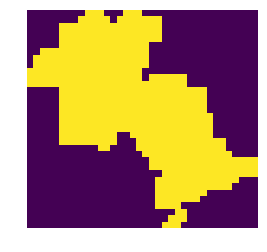

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(rasters[0])
ax.axis('off');

Salvar o geotiff.

In [15]:
with rasterio.open(
    fp='/tmp/test.tif', 
    mode='w',
    crs=shp.crs,
    driver='GTiff',
    profile='GeoTIFF',
    dtype=dtype,
    count=3,
    width=width,
    height=height,
    nodata=np.nan,
    transform=transform,
    photometric='RGB'
) as dst:
    # help(dst.write)
    for i in range(1, 4):
        print(i, rasters[i-1].shape)
        dst.write_band(i, rasters[i-1])
        # dst.write_colormap(
        #     i, {0: (255, 0, 0), 255: (0, 0, 255)}
        # )
        # print(dst.colormap(i))

1 (34, 36)
2 (34, 36)
3 (34, 36)


Round-trip

In [16]:
with rasterio.open('/tmp/test.tif') as src:
    r, g, b = src.read()
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)
    print(src.colorinterp(1))
    print(src.colorinterp(2))
    print(src.colorinterp(3))
    
    bands = (
        ('r', r),
        ('g', g),
        ('b', b)
    )
    
    for k, band in bands:
        print('\n', k, ':')
        print('min:', np.min(band))
        print('max:', np.max(band))

36 34
CRS({'init': 'epsg:4326'})
| 0.01, 0.00,-40.91|
| 0.00,-0.01,-18.84|
| 0.00, 0.00, 1.00|
3
(1, 2, 3)
ColorInterp.red
ColorInterp.green
ColorInterp.blue

 r :
min: 0.0
max: 255.0

 g :
min: 0.0
max: 0.0

 b :
min: 0.0
max: 0.0


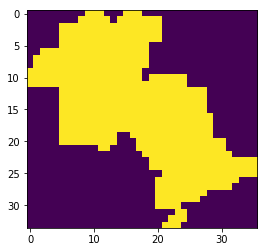

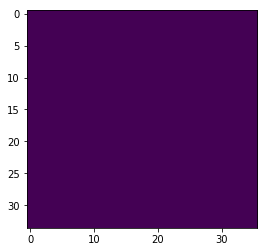

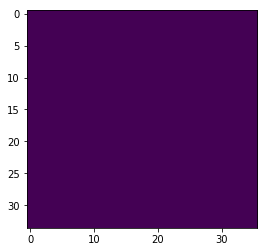

In [17]:
total = np.zeros(r.shape)
for band in r, g, b:
    plt.imshow(band)
    plt.show()
    total += band
# total /= 4

Aparentemente a figura "preta" é pq não tenho um visualizador corrento.
A `tif` parece OK mesmo salvando em 3 bandas.

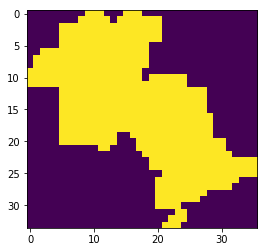

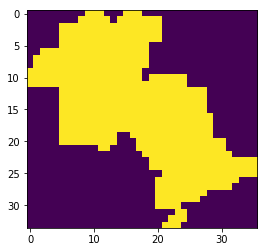

In [18]:
plt.imshow(total)
plt.show()

plt.imshow(total/3)
plt.show()

In [19]:
import pandas as pd
pd.DataFrame(total/3)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,85.0,85.0,85.0,85.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,85.0,85.0,85.0,85.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,85.0,85.0,85.0,85.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,85.0,85.0,85.0,85.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Refs

http://nbviewer.jupyter.org/gist/ocefpaf/53e5be14d58c1b946952a7293f2005cf

https://github.com/mapbox/rasterio/blob/6b02fd304d10995cff818729abe47f28bd7a33b5/examples/rasterize_geometry.py

http://docs.qgis.org/2.0/es/docs/gentle_gis_introduction/raster_data.html